In [1]:
!pip install datasets
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from datasets import Dataset


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00


In [3]:
data = pd.read_csv('CSE_584_Final_Dataset.csv')
print(data.head())

                              truncated_data  \
0            Ara will be interested when you   
1         As you know, all the medical units   
2     Till now no man there has lived beyond   
3          Maybe they got their radio turned   
4  So if somebody wanted to, say, track down   

                                      generated_data                 LLM  
0  Ara will be interested in learning more about ...    tinydolphin:1.1b  
1  can be converted to corresponding metric equiv...  mixtral-8x7b-32768  
2                                         the grave.           orca-mini  
3             up too loud, causing the interference.  mixtral-8x7b-32768  
4  potential leads or sources for a new business ...           orca-mini  


In [4]:
X_train_truncated, X_test_truncated, X_train_generated, X_test_generated = train_test_split(
    data['truncated_data'], data['generated_data'], test_size=0.2, random_state=70, shuffle=False
)

In [5]:
encode_labels = LabelEncoder()
data['numeric_label'] = encode_labels.fit_transform(data['LLM'])
label_mapping = dict(zip(encode_labels.classes_, encode_labels.transform(encode_labels.classes_)))

In [6]:
y_train, y_test = train_test_split(
    data['numeric_label'], test_size=0.2, random_state=70, shuffle=False
)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
MAX_SEQ_LEN = 128

def tokenize_pairs(xi, xj):
    xi = [str(text) for text in xi]
    xj = [str(text) for text in xj]

    encodings = tokenizer(
        xi,
        xj,
        add_special_tokens=True,
        max_length=MAX_SEQ_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encodings

In [9]:
train_encodings = tokenize_pairs(X_train_truncated.tolist(), X_train_generated.tolist())
test_encodings = tokenize_pairs(X_test_truncated.tolist(), X_test_generated.tolist())
print(train_encodings)
print(train_encodings)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[  101, 19027,  2097, ...,     0,     0,     0],
       [  101,  2004,  2017, ...,     0,     0,     0],
       [  101,  6229,  2085, ...,     0,     0,     0],
       ...,
       [  101,  1998,  2017, ...,     0,     0,     0],
       [  101,  1037,  2450, ...,     0,     0,     0],
       [  101,  2002,  2064, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y_train
)).shuffle(len(X_train_truncated)).batch(32) # batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    y_test
)).batch(32)


In [11]:

num_labels = len(encode_labels.classes_)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
EPOCHS = 3
trained_model = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/3
538/538 [==============================] - 486s 823ms/step - loss: 1.0375 - accuracy: 0.5762 - val_loss: 0.7830 - val_accuracy: 0.6895
Epoch 2/3
538/538 [==============================] - 438s 815ms/step - loss: 0.6866 - accuracy: 0.7363 - val_loss: 0.6940 - val_accuracy: 0.7341
Epoch 3/3
538/538 [==============================] - 439s 815ms/step - loss: 0.4756 - accuracy: 0.8234 - val_loss: 0.7441 - val_accuracy: 0.7262


In [13]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


135/135 [==============================] - 37s 271ms/step - loss: 0.7441 - accuracy: 0.7262
Test Loss: 0.7440772652626038
Test Accuracy: 0.7262375354766846


In [14]:
import matplotlib.pyplot as plt

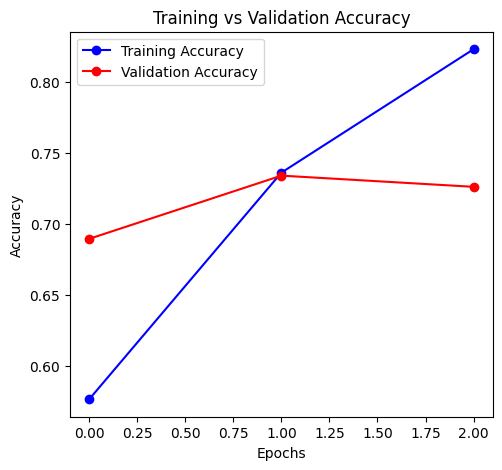

In [15]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

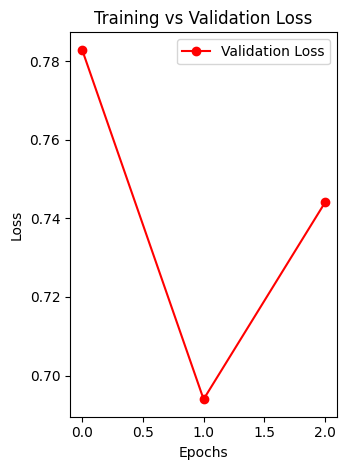

In [16]:
plt.subplot(1, 2, 2)
# plt.plot(trained_model.history['loss'], 'bo-', label='Training Loss')
plt.plot(trained_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

135/135 [==============================] - 37s 272ms/step
(4303, 5)


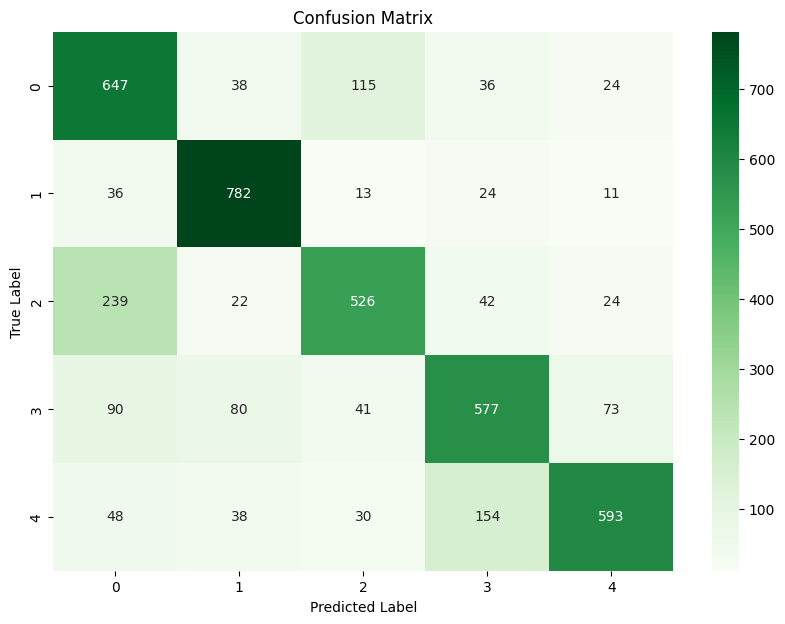

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

y_pred = model.predict(test_dataset)
y_pred_logits = y_pred.logits
print(y_pred_logits.shape)
y_pred_classes = np.argmax(y_pred_logits, axis=0) if y_pred_logits.ndim == 1 else np.argmax(y_pred_logits, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
model.save('bert')
tokenizer.save_pretrained('bert')

('bert/tokenizer_config.json',
 'bert/special_tokens_map.json',
 'bert/vocab.txt',
 'bert/added_tokens.json')

In [19]:
model.save_weights('bert')

In [20]:
tokenizer.save_pretrained('bert')

('bert/tokenizer_config.json',
 'bert/special_tokens_map.json',
 'bert/vocab.txt',
 'bert/added_tokens.json')

In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, target_names=encode_labels.classes_)
print(report)

                    precision    recall  f1-score   support

             gpt-2       0.61      0.75      0.67       860
       llama3.2:1b       0.81      0.90      0.86       866
mixtral-8x7b-32768       0.73      0.62      0.67       853
         orca-mini       0.69      0.67      0.68       861
  tinydolphin:1.1b       0.82      0.69      0.75       863

          accuracy                           0.73      4303
         macro avg       0.73      0.73      0.73      4303
      weighted avg       0.73      0.73      0.73      4303

